In [79]:
import pandas as pd
import numpy as np

In [3]:
tracts = pd.read_csv("dallas_houston_evictions_ACS_10_19.csv")
results = pd.read_csv("model_comparision_predict.csv")
tracts = tracts.drop("Unnamed: 0", axis=1)

In [28]:
cov = pd.DataFrame()

for index, row in results.iterrows():
    cov = cov.append(tracts[(tracts['GEOID'] == row['GEOID']) & (tracts['year'] == 2019) & (tracts['week'] == 52)])

In [29]:
cov = cov.drop(["Unnamed: 0", "count", "year", "week"], axis=1)

In [41]:
test_tracts = results.merge(tracts, on="GEOID")

In [42]:
test_tracts.head()

,Unnamed: 0,GEOID,nbeats,lstm,gru,brnn,average,best,worst,Best Performing,...,week,week_dt,SE_A03001_003,SE_A18005_001,SE_A06001_005,SE_B18002_002,SE_B18002_003,SE_A08002B_003,SE_A10011_003,SE_A10039B_009
0,0,4.820153e+10,0.291161,0.748392,0.516584,0.461555,0.504423,0.291161,0.748392,1,...,0,2010-01-03,2068.0,778.024194,1213.0,0.0,0.0,1047.0,269.0,241.0
1,0,4.820153e+10,0.291161,0.748392,0.516584,0.461555,0.504423,0.291161,0.748392,1,...,1,2010-01-10,2068.0,778.024194,1213.0,0.0,0.0,1047.0,269.0,241.0
2,0,4.820153e+10,0.291161,0.748392,0.516584,0.461555,0.504423,0.291161,0.748392,1,...,2,2010-01-17,2068.0,778.024194,1213.0,0.0,0.0,1047.0,269.0,241.0
3,0,4.820153e+10,0.291161,0.748392,0.516584,0.461555,0.504423,0.291161,0.748392,1,...,3,2010-01-24,2068.0,778.024194,1213.0,0.0,0.0,1047.0,269.0,241.0
4,0,4.820153e+10,0.291161,0.748392,0.516584,0.461555,0.504423,0.291161,0.748392,1,...,4,2010-01-31,2068.0,778.024194,1213.0,0.0,0.0,1047.0,269.0,241.0


Now we need a measure of the variance across the count for the tract, see here: https://bookdown.org/gary_a_napier/time_series_lecture_notes/ChapterOne.html#TSProps




In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from dateutil.parser import parse

First: do we have autocorrelation and does that help us understand which model will perform best? We'll use Ljung-Box: https://www.statology.org/ljung-box-test-python/


In [52]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_50 = []
pacf_50 = []

for geoid in test_tracts['GEOID'].unique():
    evicts = test_tracts[test_tracts['GEOID']==geoid]['count']
    acf_50.append({'geoid':geoid, 'acf':acf(evicts, nlags=50)})
    pacf_50.append({'geoid':geoid, 'acf':pacf(evicts, nlags=50)})

In [318]:
import statsmodels.api as sm

LJ_results = []

for geoid in test_tracts['GEOID'].unique():
    evicts = test_tracts[test_tracts['GEOID']==geoid]['count']
    res = sm.stats.acorr_ljungbox(evicts, lags=[10])
    LJ_results.append({"GEOID":geoid, 'tstat':res[0][0], 'p':res[1][0]})

/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [319]:
LJ_df = pd.DataFrame(LJ_results)

In [321]:
len(LJ_df) - len(LJ_df[LJ_df['p'] > 0.1])

182

In [74]:
LJ_df = LJ_df.merge(results, on="GEOID")

In [75]:
LJ_df.head()

,GEOID,tstat,p,Unnamed: 0,nbeats,lstm,gru,brnn,average,best,worst,Best Performing
0,4.820153e+10,68.498511,8.635737e-11,0,0.291161,0.748392,0.516584,0.461555,0.504423,0.291161,0.748392,1
1,4.820131e+10,150.705440,2.668523e-27,1,0.277109,0.369994,0.372488,1.144597,0.541047,0.277109,1.144597,1
2,4.811301e+10,27.984308,1.815721e-03,2,0.047349,0.067831,0.054805,0.041424,0.052852,0.041424,0.067831,4
3,4.811301e+10,27.973338,1.823077e-03,3,0.051545,0.070618,0.047575,0.093111,0.065712,0.047575,0.093111,3
4,4.820145e+10,28.699121,1.393680e-03,4,0.178281,0.063471,0.134002,0.204296,0.145013,0.063471,0.204296,2


In [77]:
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = LJ_df['p']   # independent variables
y = LJ_df['Best Performing']   # dependent variables

# fit the regression model
reg = sm.OLS(y, X).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        Best Performing   R-squared (uncentered):                   0.145
Model:                            OLS   Adj. R-squared (uncentered):              0.141
Method:                 Least Squares   F-statistic:                              37.35
Date:                Sun, 14 Nov 2021   Prob (F-statistic):                    4.43e-09
Time:                        08:18:56   Log-Likelihood:                         -475.00
No. Observations:                 221   AIC:                                      952.0
Df Residuals:                     220   BIC:                                      955.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
p              3.2870      0.538      6.112      0.000       2.227       4.347
==============================================================================
Omnibus:                        1.787   Durbin-Watson:                   0.600
Prob(Omnibus):                  0.409   Jarque-Bera (JB):                1.433
Skew:                          -0.148   Prob(JB):                        0.489
Kurtosis:                       3.261   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared is 0.145 so it seems like LjungBox might not be the best way to tell. Are there other ways to use LB?


Maybe look at ANOVA for LB?

In [120]:
from statsmodels.formula.api import ols

LJ_df = LJ_df.rename(columns={"Best Performing":'Best'})

model = ols('p ~ C(Best)', data=LJ_df).fit()
anova_table = sm.stats.anova_lm(model)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(Best),3.0,0.264927,0.088309,1.562332,0.199485
Residual,217.0,12.265661,0.056524,NaN,NaN


In [148]:
LJ_df.corr()

,GEOID,tstat,p,nbeats,lstm,gru,brnn,average,best,worst,Best
GEOID,1.000000,-0.081778,-0.031586,-0.073554,-0.077976,-0.087558,-0.081396,-0.091083,-0.089123,-0.091510,-0.026416
tstat,-0.081778,1.000000,-0.349040,0.626313,0.537255,0.684170,0.607110,0.687661,0.622604,0.649687,0.020191
p,-0.031586,-0.349040,1.000000,-0.273126,-0.213572,-0.277441,-0.250535,-0.283210,-0.238669,-0.275774,0.042686
nbeats,-0.073554,0.626313,-0.273126,1.000000,0.694641,0.796654,0.687118,0.868220,0.856891,0.780730,0.144916
lstm,-0.077976,0.537255,-0.213572,0.694641,1.000000,0.658632,0.625988,0.847183,0.859547,0.754665,-0.018228
gru,-0.087558,0.684170,-0.277441,0.796654,0.658632,1.000000,0.756347,0.886936,0.798220,0.829382,-0.149873
brnn,-0.081396,0.607110,-0.250535,0.687118,0.625988,0.756347,1.000000,0.907378,0.728445,0.964604,-0.141139
average,-0.091083,0.687661,-0.283210,0.868220,0.847183,0.886936,0.907378,1.000000,0.908104,0.966071,-0.066538
best,-0.089123,0.622604,-0.238669,0.856891,0.859547,0.798220,0.728445,0.908104,1.000000,0.805960,-0.017023
worst,-0.091510,0.649687,-0.275774,0.780730,0.754665,0.829382,0.964604,0.966071,0.805960,1.000000,-0.088368


Seems like it's better when we use best as a Category

Now let's look at Entropy:

In [38]:


# https://en.wikipedia.org/wiki/Approximate_entropy
def ApEn(U, m, r):
    """Compute Aproximate entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))

    N = len(U)
    return abs(_phi(m+1) - _phi(m))

# https://en.wikipedia.org/wiki/Sample_entropy
def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

In [105]:
SampleEntropys = []

for geoid in test_tracts['GEOID'].unique():
    e = test_tracts[test_tracts['GEOID']==geoid]['count'].tolist()
    rv = 0.2*np.std(evicts)
    SampleEntropys.append({'GEOID':geoid, 'SampEn':SampEn(e, m=2, r=rv)})

In [147]:
SE_df = pd.DataFrame(SampleEntropys)
SE_df.head()
SE_df = SE_df.merge(results, on="GEOID")
SE_df.corr()

,GEOID,SampEn,nbeats,lstm,gru,brnn,average,best,worst,Best Performing
GEOID,1.000000,-0.231067,-0.073554,-0.077976,-0.087558,-0.081396,-0.091083,-0.089123,-0.091510,-0.026416
SampEn,-0.231067,1.000000,0.621224,0.546330,0.648213,0.631226,0.692221,0.640827,0.649510,0.001004
nbeats,-0.073554,0.621224,1.000000,0.694641,0.796654,0.687118,0.868220,0.856891,0.780730,0.144916
lstm,-0.077976,0.546330,0.694641,1.000000,0.658632,0.625988,0.847183,0.859547,0.754665,-0.018228
gru,-0.087558,0.648213,0.796654,0.658632,1.000000,0.756347,0.886936,0.798220,0.829382,-0.149873
brnn,-0.081396,0.631226,0.687118,0.625988,0.756347,1.000000,0.907378,0.728445,0.964604,-0.141139
average,-0.091083,0.692221,0.868220,0.847183,0.886936,0.907378,1.000000,0.908104,0.966071,-0.066538
best,-0.089123,0.640827,0.856891,0.859547,0.798220,0.728445,0.908104,1.000000,0.805960,-0.017023
worst,-0.091510,0.649510,0.780730,0.754665,0.829382,0.964604,0.966071,0.805960,1.000000,-0.088368
Best Performing,-0.026416,0.001004,0.144916,-0.018228,-0.149873,-0.141139,-0.066538,-0.017023,-0.088368,1.000000


In [146]:


X = SE_df['SampEn']   # independent variables
y = SE_df['Best']   # dependent variables

# fit the regression model
reg = sm.OLS(y, X).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Best   R-squared (uncentered):                   0.578
Model:                            OLS   Adj. R-squared (uncentered):              0.576
Method:                 Least Squares   F-statistic:                              300.8
Date:                Mon, 15 Nov 2021   Prob (F-statistic):                    4.79e-43
Time:                        16:36:25   Log-Likelihood:                         -397.10
No. Observations:                 221   AIC:                                      796.2
Df Residuals:                     220   BIC:                                      799.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
SampEn         1.6598      0.096     17.344      0.000       1.471       1.848
==============================================================================
Omnibus:                        1.516   Durbin-Watson:                   1.618
Prob(Omnibus):                  0.469   Jarque-Bera (JB):                1.504
Skew:                          -0.198   Prob(JB):                        0.471
Kurtosis:                       2.923   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [118]:
from statsmodels.formula.api import ols

SE_df = SE_df.rename(columns={"Best Performing":'Best'})

model = ols('SampEn ~ C(Best)', data=SE_df).fit()
anova_table = sm.stats.anova_lm(model)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(Best),3.0,0.636550,0.212183,0.681664,0.564127
Residual,217.0,67.546119,0.311272,NaN,NaN


In [314]:
SE_df.corr()

,GEOID,SampEn,nbeats,lstm,gru,brnn,average,best,worst,Best Performing
GEOID,1.000000,-0.231067,-0.073554,-0.077976,-0.087558,-0.081396,-0.091083,-0.089123,-0.091510,-0.026416
SampEn,-0.231067,1.000000,0.621224,0.546330,0.648213,0.631226,0.692221,0.640827,0.649510,0.001004
nbeats,-0.073554,0.621224,1.000000,0.694641,0.796654,0.687118,0.868220,0.856891,0.780730,0.144916
lstm,-0.077976,0.546330,0.694641,1.000000,0.658632,0.625988,0.847183,0.859547,0.754665,-0.018228
gru,-0.087558,0.648213,0.796654,0.658632,1.000000,0.756347,0.886936,0.798220,0.829382,-0.149873
brnn,-0.081396,0.631226,0.687118,0.625988,0.756347,1.000000,0.907378,0.728445,0.964604,-0.141139
average,-0.091083,0.692221,0.868220,0.847183,0.886936,0.907378,1.000000,0.908104,0.966071,-0.066538
best,-0.089123,0.640827,0.856891,0.859547,0.798220,0.728445,0.908104,1.000000,0.805960,-0.017023
worst,-0.091510,0.649510,0.780730,0.754665,0.829382,0.964604,0.966071,0.805960,1.000000,-0.088368
Best Performing,-0.026416,0.001004,0.144916,-0.018228,-0.149873,-0.141139,-0.066538,-0.017023,-0.088368,1.000000


That's not doing a ton for us. Maybe look at ADFuller and KPSS to see if the stationarity of our Time Series is a good predictor?

Here's a reference: https://towardsdatascience.com/most-useful-python-functions-for-time-series-analysis-ed1a9cb3aa8b

In [128]:
from statsmodels.tsa.stattools import adfuller, kpss

stationarity_results = []

for geoid in test_tracts['GEOID'].unique():
    e = test_tracts[test_tracts['GEOID']==geoid]['count'].tolist()
    # ADF Test
    adf = adfuller(e, autolag='AIC')
    # KPSS Test
    stats, p, lags, critical_values = kpss(e, 'ct')
    stationarity_results.append({'GEOID':geoid, 'adf':adf[1], 'kpss_p':p})

/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/joshnoble/opt/anacond

/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sampl

/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sampl

/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/joshnoble/opt/anacond

/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/joshnoble/opt/anacond

/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sampl

/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/joshnoble/opt/anacond

/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sampl

/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sampl

/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sampl

/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sampl

/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater tha

/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/joshnoble/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/joshnoble/opt/anacond

In [131]:
stationarity_df = pd.DataFrame(stationarity_results)
stationarity_df = stationarity_df.merge(results, on="GEOID")

In [234]:
print(len(stationarity_df[(stationarity_df['kpss_p'] < 0.05)]))
print(len(stationarity_df[(stationarity_df['adf'] > 0.05)]))
print(len(stationarity_df[(stationarity_df['adf'] > 0.05) & (stationarity_df['kpss_p'] < 0.05)]))

99
27
21


In [235]:
stationarity_df = stationarity_df.rename(columns={"Best Performing":'Best'})

model = ols('adf ~ C(Best)', data=stationarity_df).fit()
anova_table = sm.stats.anova_lm(model)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(Best),3.0,0.026556,0.008852,0.988718,0.398955
Residual,217.0,1.942805,0.008953,NaN,NaN


In [236]:
model = ols('kpss_p ~ C(Best)', data=stationarity_df).fit()
anova_table = sm.stats.anova_lm(model)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(Best),3.0,0.001148,0.000383,0.237159,0.87039
Residual,217.0,0.350100,0.001613,NaN,NaN


In [140]:

X = stationarity_df[['adf', 'kpss_p']]   # independent variables
y = stationarity_df['Best']   # dependent variables

# fit the regression model
reg = sm.OLS(y, X).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   Best   R-squared (uncentered):                   0.602
Model:                            OLS   Adj. R-squared (uncentered):              0.598
Method:                 Least Squares   F-statistic:                              165.3
Date:                Sun, 14 Nov 2021   Prob (F-statistic):                    1.75e-44
Time:                        10:20:02   Log-Likelihood:                         -390.65
No. Observations:                 221   AIC:                                      785.3
Df Residuals:                     219   BIC:                                      792.1
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
adf            5.0163      0.977      5.135      0.000       3.091       6.942
kpss_p        22.3351      1.326     16.850      0.000      19.723      24.947
==============================================================================
Omnibus:                       12.382   Durbin-Watson:                   1.568
Prob(Omnibus):                  0.002   Jarque-Bera (JB):                8.464
Skew:                           0.350   Prob(JB):                       0.0145
Kurtosis:                       2.345   Cond. No.                         1.38
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [144]:
stationarity_df.corr()

,GEOID,adf,kpss_p,nbeats,lstm,gru,brnn,average,best,worst,Best
GEOID,1.000000,-0.043443,-0.038700,-0.073554,-0.077976,-0.087558,-0.081396,-0.091083,-0.089123,-0.091510,-0.026416
adf,-0.043443,1.000000,-0.266532,0.262078,0.215398,0.278701,0.210254,0.264866,0.153936,0.271082,0.080667
kpss_p,-0.038700,-0.266532,1.000000,-0.198760,-0.147539,-0.225432,-0.202138,-0.216818,-0.144965,-0.227767,-0.044845
nbeats,-0.073554,0.262078,-0.198760,1.000000,0.694641,0.796654,0.687118,0.868220,0.856891,0.780730,0.144916
lstm,-0.077976,0.215398,-0.147539,0.694641,1.000000,0.658632,0.625988,0.847183,0.859547,0.754665,-0.018228
gru,-0.087558,0.278701,-0.225432,0.796654,0.658632,1.000000,0.756347,0.886936,0.798220,0.829382,-0.149873
brnn,-0.081396,0.210254,-0.202138,0.687118,0.625988,0.756347,1.000000,0.907378,0.728445,0.964604,-0.141139
average,-0.091083,0.264866,-0.216818,0.868220,0.847183,0.886936,0.907378,1.000000,0.908104,0.966071,-0.066538
best,-0.089123,0.153936,-0.144965,0.856891,0.859547,0.798220,0.728445,0.908104,1.000000,0.805960,-0.017023
worst,-0.091510,0.271082,-0.227767,0.780730,0.754665,0.829382,0.964604,0.966071,0.805960,1.000000,-0.088368


In [263]:
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy import signal

filtering = []

for geoid in test_tracts['GEOID'].unique():
    evicts = test_tracts[test_tracts['GEOID']==geoid]['count']
    detrend = np.sum(signal.detrend(evicts))
    hp_cycle, hp_trend = hpfilter(evicts)
    result = seasonal_decompose(evicts, model = "add", period = 4)
    res_range = np.min(result.resid) - np.max(result.resid)
    diff = np.sum(evicts.diff())
    filtering.append({'geoid':geoid, 
                      'hp_cycle':hp_cycle, 
                      "hp_trend":hp_trend, 
                      'diff':np.max(diff), 
                      'detrend':detrend,#abs(np.max(detrend) - np.min(detrend)), 
                      'res':abs(res_range),
                      'best':test_tracts[test_tracts['GEOID']==geoid]['Best Performing'].unique()[0],
                      'range':abs(np.max(evicts) - np.min(evicts))
                     })

<AxesSubplot:ylabel='Frequency'>

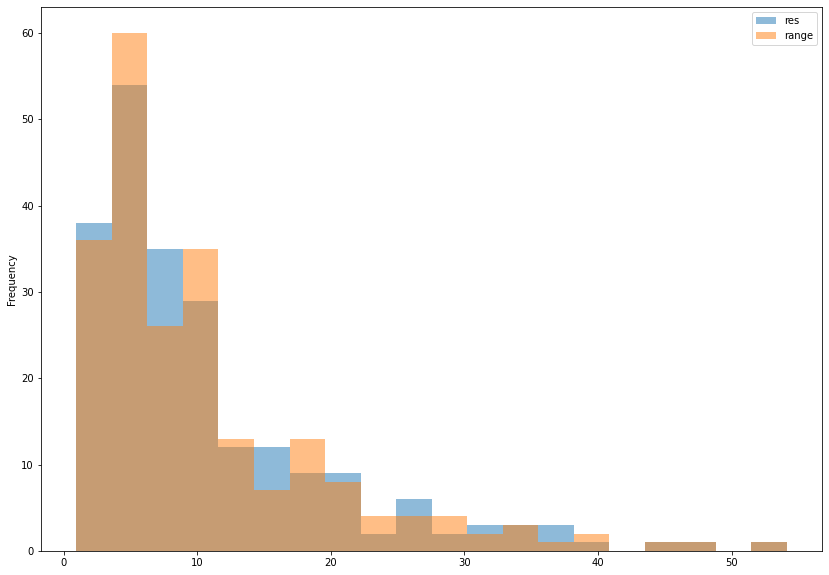

In [239]:
filtering_df = pd.DataFrame(filtering)
filtering_df[['res', 'range']].plot.hist(bins=20, alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

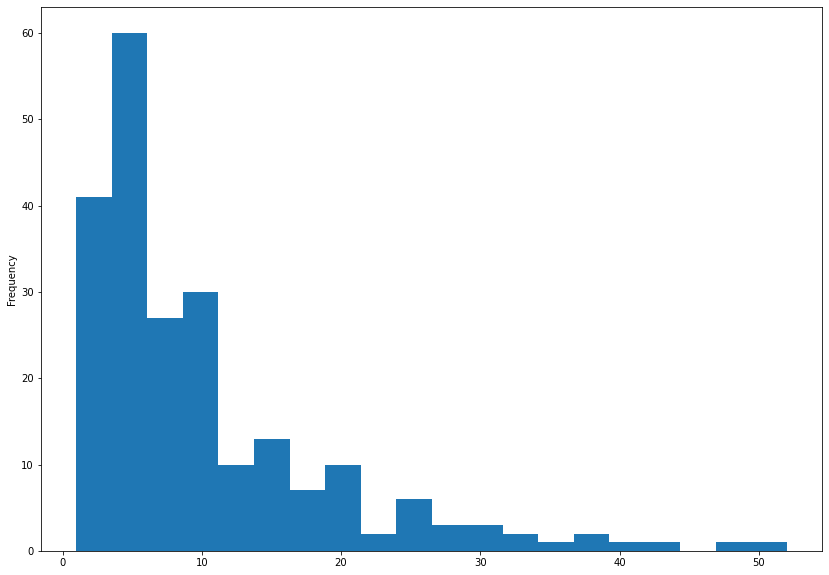

In [264]:
filtering_df['diff'].plot.hist(bins=20)

In [265]:
filtering_df.corr()

,geoid,diff,detrend,res,best,range
geoid,1.000000,-0.019776,-0.018724,-0.026430,-0.026416,-0.024662
diff,-0.019776,1.000000,0.996827,0.995091,0.002315,0.997436
detrend,-0.018724,0.996827,1.000000,0.996412,0.009217,0.998810
res,-0.026430,0.995091,0.996412,1.000000,0.004201,0.996084
best,-0.026416,0.002315,0.009217,0.004201,1.000000,0.011214
range,-0.024662,0.997436,0.998810,0.996084,0.011214,1.000000


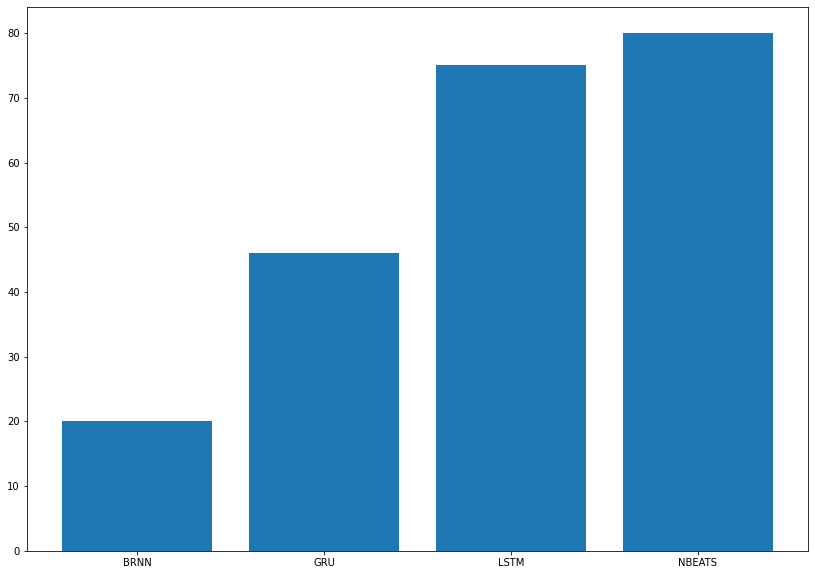

In [259]:
model_map = {1:"NBEATS", 2:"LSTM", 3:"GRU", 4:"BRNN"}
filtering_df['best_name'] = filtering_df['best'].map(model_map)
# ax = filtering_df['best_name'].hist(align='right')
# ax.grid(False)
# plt.show()


labels, counts = np.unique(filtering_df['best_name'], return_counts=True)
plt.bar(labels, counts)
plt.show()

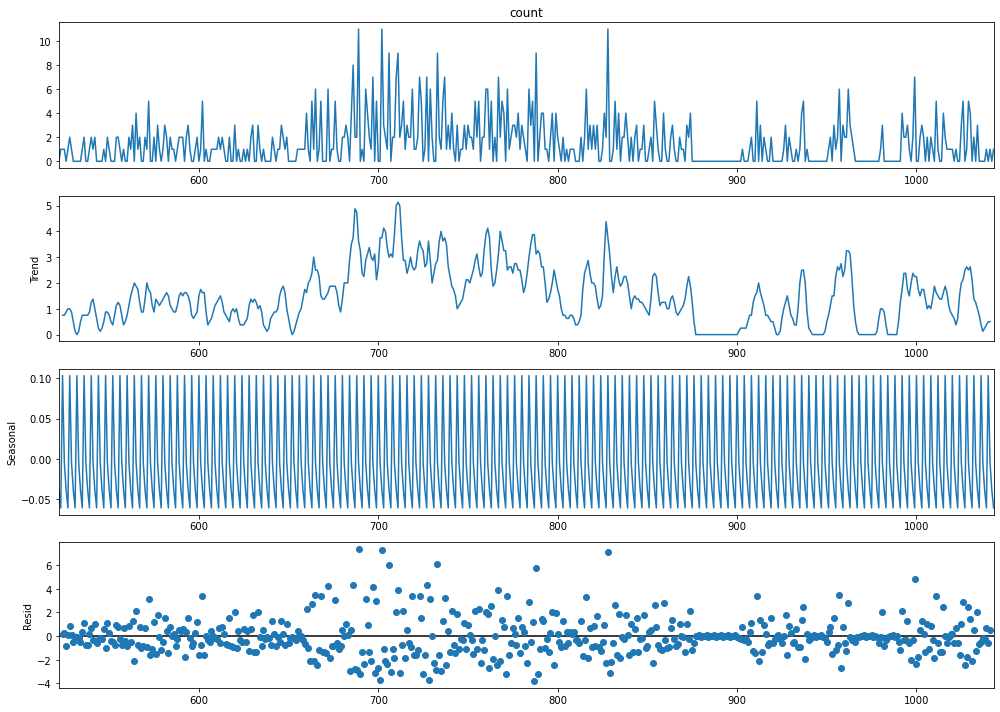

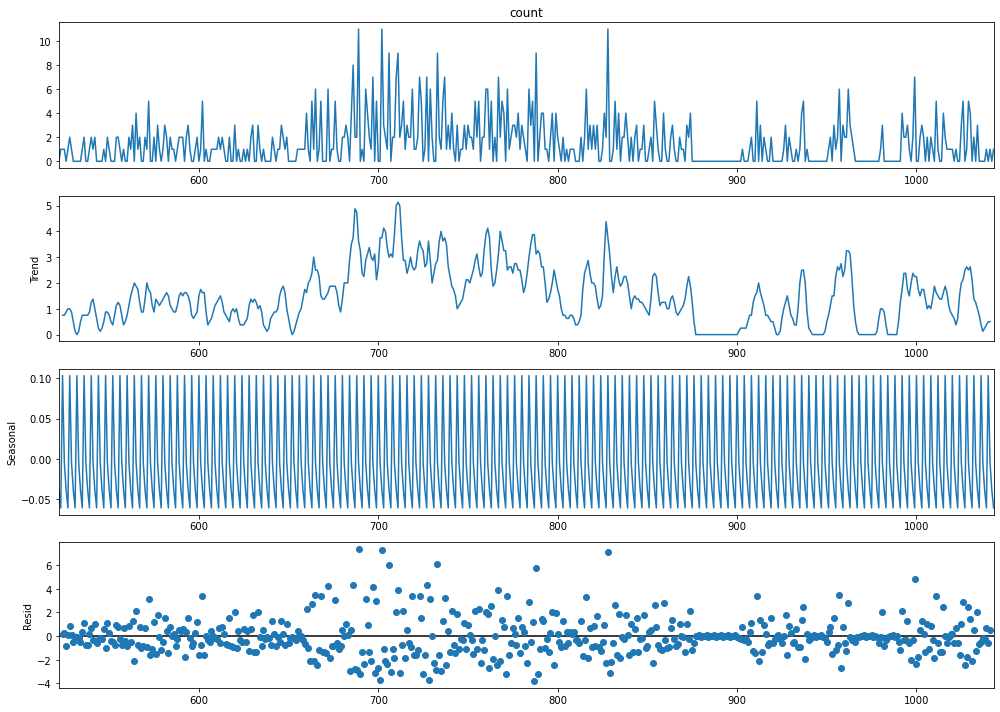

In [173]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

test_evicts = test_tracts[test_tracts['GEOID']==test_tracts['GEOID'].unique()[1]]['count']
result = seasonal_decompose(test_evicts, model = "add", period = 4)
plt.rc("figure", figsize=(14,10))
result.plot()

In [171]:
np.min(result.resid) - np.max(result.resid)

-11.19376863446631

In [281]:
test_tracts.head()

,Unnamed: 0,GEOID,nbeats,lstm,gru,brnn,average,best,worst,Best Performing,...,week,week_dt,SE_A03001_003,SE_A18005_001,SE_A06001_005,SE_B18002_002,SE_B18002_003,SE_A08002B_003,SE_A10011_003,SE_A10039B_009
0,0,4.820153e+10,0.291161,0.748392,0.516584,0.461555,0.504423,0.291161,0.748392,1,...,0,2010-01-03,2068.0,778.024194,1213.0,0.0,0.0,1047.0,269.0,241.0
1,0,4.820153e+10,0.291161,0.748392,0.516584,0.461555,0.504423,0.291161,0.748392,1,...,1,2010-01-10,2068.0,778.024194,1213.0,0.0,0.0,1047.0,269.0,241.0
2,0,4.820153e+10,0.291161,0.748392,0.516584,0.461555,0.504423,0.291161,0.748392,1,...,2,2010-01-17,2068.0,778.024194,1213.0,0.0,0.0,1047.0,269.0,241.0
3,0,4.820153e+10,0.291161,0.748392,0.516584,0.461555,0.504423,0.291161,0.748392,1,...,3,2010-01-24,2068.0,778.024194,1213.0,0.0,0.0,1047.0,269.0,241.0
4,0,4.820153e+10,0.291161,0.748392,0.516584,0.461555,0.504423,0.291161,0.748392,1,...,4,2010-01-31,2068.0,778.024194,1213.0,0.0,0.0,1047.0,269.0,241.0


In [282]:
from tsfresh import extract_features

test_tract = test_tracts[test_tracts['GEOID']==test_tracts['GEOID'].unique()[1]][['GEOID', 'week_dt', 'count']]

extracted_features = extract_features(test_tract, column_id="GEOID", column_sort="week_dt", column_value="count")

Feature Extraction: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.39s/it]


In [315]:
extracted_features['count__matrix_profile__feature_"max"__threshold_0.98'].tolist()[0]

5.656854249492381

In [316]:

extracted_feature_sets = []

for geoid in test_tracts['GEOID'].unique():
    t = test_tracts[test_tracts['GEOID']==geoid]
    ef = extract_features(t, column_id="GEOID", column_sort="week_dt", column_value="count")
    extracted_feature_sets.append({'GEOID':t['GEOID'],
                                    'best':t['Best Performing'].unique()[0],
                                    'energy':ef['count__abs_energy'].tolist()[0],
                                   'sum':ef['count__sum_values'].tolist()[0],
                                   'mean_abs_change':ef['count__mean_abs_change'].tolist()[0],
                                   "mean_change":ef['count__mean_change'].tolist()[0],
                                   "dim5":ef['count__permutation_entropy__dimension_5__tau_1'].tolist()[0],
                                   'min98':ef['count__matrix_profile__feature_"min"__threshold_0.98'].tolist()[0],
                                   'max98':ef['count__matrix_profile__feature_"max"__threshold_0.98'].tolist()[0]
                                  })

Feature Extraction: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.90s/it]


Feature Extraction: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.95s/it]


Feature Extraction: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.95s/it]


Feature Extraction: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.39s/it]


Feature Extraction: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.14s/it]


Feature Extraction: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.17s/it]


In [312]:
for e in extracted_feature_sets:
    e['best'] = e['best'][0]

In [317]:
ef_df = pd.DataFrame(extracted_feature_sets)
ef_df.corr()

,best,energy,sum,mean_abs_change,mean_change,dim5,min98,max98
best,1.000000,-0.022424,-0.019169,0.001230,0.073713,-0.009080,-0.002967,-0.025294
energy,-0.022424,1.000000,0.927432,0.910244,0.522570,0.431090,-0.286091,-0.309321
sum,-0.019169,0.927432,1.000000,0.985667,0.511132,0.683009,-0.474406,-0.511675
mean_abs_change,0.001230,0.910244,0.985667,1.000000,0.480563,0.685008,-0.491147,-0.515702
mean_change,0.073713,0.522570,0.511132,0.480563,1.000000,0.311564,-0.226365,-0.254426
dim5,-0.009080,0.431090,0.683009,0.685008,0.311564,1.000000,-0.801540,-0.846875
min98,-0.002967,-0.286091,-0.474406,-0.491147,-0.226365,-0.801540,1.000000,0.840860
max98,-0.025294,-0.309321,-0.511675,-0.515702,-0.254426,-0.846875,0.840860,1.000000


None of these seem to be super great

What other things might we try?